<a href="https://colab.research.google.com/github/pejmanS21/ComputerVision_Collections/blob/main/%F0%9F%8D%95_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%bash
pip install -q kaggle
cp -r /content/drive/MyDrive/.kaggle ~/

In [3]:
%%bash
kaggle datasets download -d carlosrunner/pizza-not-pizza
unzip -q /content/pizza-not-pizza.zip

100%|██████████| 101M/101M [00:00<00:00, 108MB/s] 


In [4]:
!pip install -q torchsummary

In [5]:
!pip install -q comet_ml 

     |████████████████████████████████| 361 kB 5.1 MB/s 
     |████████████████████████████████| 145 kB 65.3 MB/s 
     |████████████████████████████████| 54 kB 176 kB/s 
     |████████████████████████████████| 554 kB 41.6 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 


In [6]:
import os
os.environ["COMET_URL_OVERRIDE"] = "https://www.comet.com/clientlib/"

# Import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="jcLSVkYoj5DHp5APmhEVnx065",
    project_name="pizza-detector",
    workspace="pejmans21",
    log_code=True
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: Failed to calculate active processors count. Fall back to default CPU count 1
COMET INFO: Experiment is live on comet.ml https://www.comet.com/pejmans21/pizza-detector/123c56d974cd40d492e96b64fb0a44ec

COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`


In [7]:
# !pip install pillow==9.0

In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid, save_image
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torchsummary import summary
from PIL import Image
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os

In [8]:
PATH = '/content/pizza_not_pizza/'
Folders = ['not_pizza', 'pizza']
# stats = (0.5,), (0.5,)
stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
size = 224
batch_size = 64
channels = 3

transformer = T.Compose([
    T.Resize(size), 
    T.CenterCrop(size),
    T.ToTensor(),
    T.Normalize(*stats)
])

In [9]:
dataset = ImageFolder('/content/pizza_not_pizza', transform=transformer)

print(len(dataset), dataset.classes)

1966 ['not_pizza', 'pizza']


In [10]:
learning_rate = 1e-4
n_epochs = 10

In [11]:
hyper_params = {
    "sequence_length": size,
    "input_size": size,
    "num_classes": len(dataset.classes),
    "batch_size": batch_size,
    "num_epochs": n_epochs,
    "learning_rate": learning_rate
}

experiment.log_parameters(hyper_params)

In [12]:
torch.manual_seed(42)

len_val = int(len(dataset) * 0.1)

train_ds, val_ds = random_split(dataset, [len(dataset) - len_val, len_val])

print(len(train_ds), len(val_ds))

1770 196


In [13]:
dl = DataLoader(dataset, batch_size=batch_size, 
                shuffle=True, pin_memory=True)

val_dl = DataLoader(val_ds, batch_size=batch_size, 
                    shuffle=True, pin_memory=False)

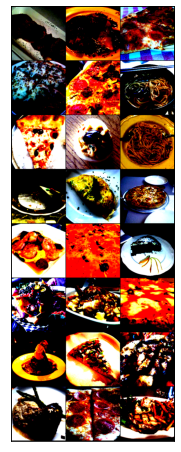

In [14]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:24], nrow=3).permute(1, 2, 0).clamp(0,1))
        break

show_batch(dl)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [16]:
class PIZZA_DETECTOR(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.mobilenet_v2(pretrained=True)
        # Replace last layer
        self.network.classifier[1] = nn.Linear(
                        self.network.classifier[1].in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)
    
    def summery(self, input_size):
        return summary(self, input_size)

In [17]:
model = PIZZA_DETECTOR(num_classes=2).to(device)
model.summery((3, 224, 224))

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
def train(epoch, n_epochs, model, dl, loss_func, 
          device, optimizer, ds=dataset):
    model.train(True)
    torch.set_grad_enabled(True)
    
    epoch_loss = 0.0
    epochs_acc = 0
    
    tq_batch = tqdm(dl, total=len(dl))
    for images, labels in tq_batch:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outs = model(images)
        _, preds = torch.max(outs, 1)
        
        loss = loss_func(outs, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epochs_acc += torch.sum(preds == labels).item()
        
        tq_batch.set_description(f'Epoch [{epoch + 1}/{n_epochs}]')
        tq_batch.set_postfix_str('loss = {:.4f}'.format(loss.item()))

            
    epoch_loss = epoch_loss / len(dl)
    epochs_acc = epochs_acc / len(ds)

    return epoch_loss, epochs_acc

In [25]:
def evaluate(model, dl, loss_func, device, ds=val_ds):

    model.train(False)

    epoch_loss = 0
    epochs_acc = 0
    tq_batch = tqdm(dl, total=len(dl), leave=False)
    for images, labels in tq_batch:

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = loss_func(outputs, labels)

        epoch_loss += loss.item()
        epochs_acc += torch.sum(preds == labels).item()
        tq_batch.set_description(f'Evaluate Model')
        
    epoch_loss = epoch_loss / len(dl)
    epochs_acc = epochs_acc / len(ds)

    return epoch_loss, epochs_acc

In [26]:
def fit(n_epochs, model, train_dataloader, valid_dataloader, 
        loss_func, device, optimizer, comet_exp):
    
    history = []
    val_loss_ref = float('inf')
    patient = 5
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        
        loss, acc = train(epoch, n_epochs, model, train_dataloader, 
                          loss_func, device, optimizer)
        val_loss, val_acc = evaluate(model, valid_dataloader, 
                                     loss_func, device)
        
        history.append({'loss': loss, 'acc': acc, 
                        'val_loss': val_loss, 'val_acc': val_acc})

        # ----------------------------------------
        comet_exp.log_metric("accuracy", acc, step=epoch)
        comet_exp.log_metric("loss", loss, step=epoch)
        comet_exp.log_metric("val_accuracy", val_acc, step=epoch)
        comet_exp.log_metric("val_loss", val_loss, step=epoch)
        # ----------------------------------------

        statement = "[loss]={:.4f} - [acc]={:.4f} - \
[val_loss]={:.4f} - [val_acc]={:.4f}".format(loss, acc, val_loss, val_acc,)
        print(statement)
        ####### Checkpoint
        if val_loss < val_loss_ref:
            patient = 5
            val_loss_ref = val_loss
            model_path = './covid_ct_mobile_checkpoint.pth'
            torch.save(model.state_dict(), model_path)
            print(f"[INFO] Saving model dict, Epoch={epoch + 1}")
        else:
            if patient == 0: 
                break
            print(f"[INFO] {patient} lives left!")
            patient -= 1
            

    return history

In [27]:
res = fit(n_epochs, model, dl, val_dl, criterion, 
          device, optimizer, comet_exp=experiment)

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[loss]=0.0063 - [acc]=0.9990 - [val_loss]=0.0007 - [val_acc]=1.0000
[INFO] Saving model dict, Epoch=1


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[loss]=0.0029 - [acc]=0.9995 - [val_loss]=0.0008 - [val_acc]=1.0000
[INFO] 5 lives left!


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[loss]=0.0022 - [acc]=1.0000 - [val_loss]=0.0002 - [val_acc]=1.0000
[INFO] Saving model dict, Epoch=3


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[loss]=0.0020 - [acc]=0.9995 - [val_loss]=0.0002 - [val_acc]=1.0000
[INFO] Saving model dict, Epoch=4


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[loss]=0.0011 - [acc]=1.0000 - [val_loss]=0.0001 - [val_acc]=1.0000
[INFO] Saving model dict, Epoch=5


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[loss]=0.0004 - [acc]=1.0000 - [val_loss]=0.0001 - [val_acc]=1.0000
[INFO] Saving model dict, Epoch=6


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[loss]=0.0005 - [acc]=1.0000 - [val_loss]=0.0001 - [val_acc]=1.0000
[INFO] 5 lives left!


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[loss]=0.0003 - [acc]=1.0000 - [val_loss]=0.0001 - [val_acc]=1.0000
[INFO] Saving model dict, Epoch=8


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[loss]=0.0010 - [acc]=1.0000 - [val_loss]=0.0001 - [val_acc]=1.0000
[INFO] 5 lives left!


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[loss]=0.0003 - [acc]=1.0000 - [val_loss]=0.0001 - [val_acc]=1.0000
[INFO] 4 lives left!


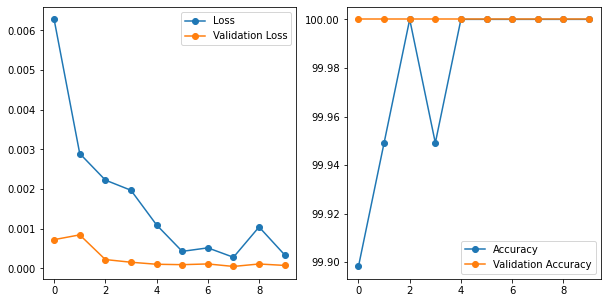

In [28]:
def show_results(history):
    accuracy = [res['acc'] for res in history]
    losses = [res['loss'] for res in history]
    val_accuracy = [res['val_acc'] for res in history]
    val_losses = [res['val_loss'] for res in history]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
    ax1.plot(losses, '-o', label = 'Loss')
    ax1.plot(val_losses, '-o', label = 'Validation Loss')
    ax1.legend()

    ax2.plot(100 * np.array(accuracy), '-o', label = 'Accuracy')
    ax2.plot(100 * np.array(val_accuracy), '-o', label = 'Validation Accuracy')
    ax2.legend();
    
    fig.show()

show_results(res)